In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from toolbox import get_pred_angle_diff_data, load_file_all_properties
import sys
import argparse
import os
import time
import pickle
from NuRadioReco.utilities import units
from scipy import stats
from radiotools import stats as rtSTATS
from termcolor import colored
from mpl_toolkits.mplot3d import Axes3D
from itertools import product, combinations
from radiotools import plthelpers as php
from tensorflow import keras
from radiotools import helper as hp
import datasets
# -------

# (MODEL, DATASET)
comparisons = [
    ("ARZHADEM", "ARZHAD"),
    ("ARZHAD", "ARZHADEM"),
    ("ARZHAD", "ARZHAD"),
    ("ARZHADEM", "ARZHADEM"),
    ("ALVAREZHAD", "ARZHAD"),
    ("ARZHAD", "ALVAREZHAD"),
    ("ARZHAD", "ARZHAD"),
    ("ALVAREZHAD", "ALVAREZHAD"),
]

for model_tag, dataset_tag in comparisons:
    prediction_file = f"predictions/model:{model_tag}-dataset:{dataset_tag}.h5_predicted.pkl"

    project_name = "nu-dir-reco"
    # run_version = "runF1"
    dataset_name = "SouthPole"

    # Dataset setup
    # Call Dataset(dataset_name, em, noise) with
    #     dataset_name:
    #         ALVAREZ (only had + noise) / ARZ
    #     em:
    #         True / False (default)
    #     noise:
    #         True (default) / False
    if (dataset_tag == "ALVAREZHAD"):
        dataset_name = "ALVAREZ"
        dataset_em = False
        dataset_noise = True
    elif (dataset_tag == "ARZHAD"):
        dataset_name = "ARZ"
        dataset_em = False
        dataset_noise = True
    elif (dataset_tag == "ARZHADEM"):
        dataset_name = "ARZ"
        dataset_em = True
        dataset_noise = True
    else: raise Exception()

    dataset = datasets.Dataset(dataset_name, dataset_em, dataset_noise)

    test_file_ids = dataset.test_file_ids
    datapath = dataset.datapath
    data_filename = dataset.data_filename
    label_filename = dataset.label_filename
    n_files = dataset.n_files
    n_files_val = dataset.n_files_val

    # Directories
    plots_dir = "plots"

    # def plot_same(x_data, ax1_data_y, ax2_data_y):
    #     print(f"Plotting {file_name}...")

    #     fig_same, ax1 = plt.subplots()

    #     ax1.set_xlabel(x_label)
    #     ax1.set_ylabel(ax1_y_label)

    #     # Set ax1 to high order to make it be in front so label is in front, and datapoints
    #     #ax1.set_zorder(1)

    #     if file_name == "nu_energy":
    #         ax1.set_xscale('log')

    #     # Remove last peices of data as their bins are weird for some azimuth
    #     if file_name == "nu_energy" or file_name == "nu_azimuth" or file_name == "nu_SNR":
    #         x_data = x_data[0:-1]
    #         ax1_data_y = ax1_data_y[0:-1]
    #         ax2_data_y = ax2_data_y[0:-1]

    #     # Remove any bins with zero events for nu_zenith
    #     if file_name == "nu_zenith":
    #         ind_count_not_0 = ax2_data_y != 0
    #         x_data = x_data[ind_count_not_0]
    #         ax1_data_y = ax1_data_y[ind_count_not_0]
    #         ax2_data_y = ax2_data_y[ind_count_not_0]

    #     lns1 = ax1.plot(x_data, ax1_data_y, "*", color=ax1_color, label = ax1_y_label)

    #     ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    #     ax2.set_ylabel(ax2_y_label) # we already handled the x-label with ax1
    #     lns2 = ax2.plot(x_data, ax2_data_y, "^", color=ax2_color, label = ax2_y_label)

    #     # Set axis limits so they are same on all plots
    #     if file_name == "nu_energy":
    #         ax1.set_ylim(0, 13.5)
    #         ax2.set_ylim(0, 27000)
    #     elif file_name == "nu_SNR":
    #         ax2.set_yscale('log')
    #         ax1.set_ylim(0, 22.5)
    #         ax2.set_ylim(9, 2e5)
    #     elif file_name == "nu_zenith":
    #         ax2.set_yscale('log')
    #         ax1.set_ylim(0, 40)
    #         ax2.set_ylim(1.1, 300000)
    #     elif file_name == "nu_azimuth":
    #         ax1.set_ylim(0, 8)
    #         ax2.set_ylim(0, 13500)

    #     plt.title(plot_title)

    #     # added these three lines
    #     lns = lns1+lns2
    #     labs = [l.get_label() for l in lns]
    #     ax1.legend(lns, labs, loc=legend_loc)

    #     fig_same.tight_layout()  # otherwise the right y-label is slightly clipped

    #     #plt.subplots_adjust(top=0.88)
    #     if eps:
    #         fig_same.savefig(f"{plot_dir}/sigma68_{file_name}_same_{run_name}_statistic_{statistic_string}.eps", format="eps", bbox_inches='tight')
    #     else:
    #         fig_same.savefig(f"{plot_dir}/sigma68_{file_name}_same_{run_name}_statistic_{statistic_string}.png", bbox_inches='tight')


    # Save the run name
    run_name = f"run_{model_tag}_vs_{dataset_tag}"

    if model_tag == "ALVAREZHAD":
        model_label = "Alvarez2009 (had.)"
    elif model_tag == "ARZHAD":
        model_label = "ARZ2020 (had.)"
    elif model_tag == "ARZHADEM":
        model_label = "ARZ2020 (had. + EM)"
    else: raise Exception()

    if dataset_tag == "ALVAREZHAD":
        dataset_label = "Alvarez2009 (had.)"
    elif dataset_tag == "ARZHAD":
        dataset_label = "ARZ2020 (had.)"
    elif dataset_tag == "ARZHADEM":
        dataset_label = "ARZ2020 (had. + EM)"
    else: raise Exception()
    
    emission_model = f"{model_label} model, {dataset_label} dataset"
    
    print(f"Plotting resolution as function of neutrino properties for {emission_model}...")

    # Define 68 % interval statistic function
    def calculate_percentage_interval(angle_difference_data):
        percentage=0.68
        N = angle_difference_data.size
        weights = np.ones(N)

        angle = rtSTATS.quantile_1d(angle_difference_data, weights, percentage)

        return angle


    # See which statistic to calculate...
    # if median:
    #     print("ITS MEDIAN!")
    #     statistic = "median"
    #     statistic_string = "Median"
    # else:
    #     statistic = "mean"
    #     statistic_string = "Mean"


    print("ITS SIXTYEIGHT!")
    statistic = calculate_percentage_interval
    statistic_string = "SIXTYEIGHT"

    print(f"Calulating with statistic {statistic_string}...")


    # Make sure plots folder exists
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)

    plot_dir = f"{plots_dir}/{run_name}_plots"
    plot_dir_old = f"{plots_dir}/{run_name}_plots/old"

    # Make sure folder inside plot_folder exists for the plots
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

    # Make sure folder inside plot_folder exists for the plots
    if not os.path.exists(plot_dir_old):
        os.makedirs(plot_dir_old)


    # # Make sure predicted file exists, otherwise run evaluator
    # prediction_file = f'{plots_dir}/model.{run_name}.h5_predicted.pkl'
    # if not os.path.isfile(prediction_file):
    #     print("Prediction file does not exist, running evaluator...")
    #     os.system(f"python evaluator.py")

     # Load test file data
        # Load first file
    data, nu_direction, nu_zenith, nu_azimuth, nu_energy, nu_flavor, shower_energy = load_file_all_properties(test_file_ids[0], dataset, plots_dir)

        # Then load rest of files
    if len(test_file_ids) > 1:
        for test_file_id in test_file_ids:
            if test_file_id != test_file_ids[0]:
                data_tmp, nu_direction_tmp, nu_zenith_tmp, nu_azimuth_tmp, nu_energy_tmp, nu_flavor_tmp, shower_energy_tmp = load_file_all_properties(test_file_id, dataset, plots_dir)

                data = np.concatenate((data, data_tmp))
                nu_direction = np.concatenate((nu_direction, nu_direction_tmp))
                nu_zenith = np.concatenate((nu_zenith, nu_zenith_tmp))
                nu_azimuth = np.concatenate((nu_azimuth, nu_azimuth_tmp))
                nu_energy = np.concatenate((nu_energy, nu_energy_tmp))
                nu_flavor = np.concatenate((nu_flavor, nu_flavor_tmp))
                shower_energy = np.concatenate((shower_energy, shower_energy_tmp))

    
    # Get angle difference data
    angle_difference_data = get_pred_angle_diff_data(run_name, dataset, plots_dir, prediction_file)

    sigma_68_string = "_{68}"

    # --------- Energy plotting ---------
    # Create figure
    fig_energy = plt.figure()

    # Calculate binned statistics
    ax = fig_energy.add_subplot(1, 1, 1)
    nu_energy_bins = np.logspace(np.log10(1e17),np.log10(10**19), 30)
    nu_energy_bins_with_one_extra = np.append(np.logspace(np.log10(1e17),np.log10(10**19), 30), [1e20])
    binned_resolution_nu_energy = stats.binned_statistic(nu_energy, angle_difference_data, bins = nu_energy_bins_with_one_extra, statistic=statistic)[0]

    ax.plot(nu_energy_bins, binned_resolution_nu_energy, "*", color="darkorange")
    # ax.set_ylim(0, 0.4)
    ax.set_xlabel(r"True $\nu$ energy (eV)")
    ax.set_ylabel(r"Mean $\sigma_{68}$ in bin (°)")
    ax.set_xscale('log')


    # ax = fig_energy.add_subplot(1, 2, 2)
    # ax.plot(nu_energy, angle_difference_data, 'o')
    # ax.set_xscale('log')


    plt.title(fr"Mean value of $\sigma{sigma_68_string}$ as a function of $\nu$ energy for dataset {emission_model}")
    fig_energy.tight_layout()
    fig_energy.savefig(f"{plot_dir_old}/{statistic_string}_resolution_nu_energy_{run_name}.png")
    # ___________________________________

    # --------- Energy count plotting ---------
    # Create figure
    fig_energy_count = plt.figure()

    # Calculate binned statistics
    ax = fig_energy_count.add_subplot(1, 1, 1)
    binned_resolution_nu_energy_count = stats.binned_statistic(nu_energy, angle_difference_data, bins = nu_energy_bins_with_one_extra, statistic = "count")[0]

    ax.plot(nu_energy_bins, binned_resolution_nu_energy_count, "*")
    # ax.set_ylim(0, 0.4)
    ax.set_xlabel(r"True $\nu$ energy (eV)")
    ax.set_ylabel("Events")
    ax.set_xscale('log')

    plt.title(fr"Count of events inside $\nu$ energy bins for dataset {emission_model}")
    fig_energy_count.tight_layout()
    fig_energy_count.savefig(f"{plot_dir_old}/{statistic_string}_resolution_nu_energy_count_{run_name}.png")
    # ___________________________________

    # Energy resolution & count on same axis
    # Constants:
    ax1_color = 'tab:blue'
    ax2_color = 'tab:orange'
    x_label = r"True $\nu$ energy (eV)"
    ax1_y_label = fr"$\sigma{sigma_68_string}$ in bin (°)"
    ax2_y_label = "Events"

    x_data = nu_energy_bins
    ax1_data_y = binned_resolution_nu_energy
    ax2_data_y = binned_resolution_nu_energy_count

    file_name = "nu_energy"
    plot_title_1 = fr"Value of $\sigma{sigma_68_string}$ as a function of $\nu$ energy"
    plot_title_2 = fr"count of events inside $\nu$ energy bins for dataset {emission_model}"
    plot_title = plot_title_1 + ", and\n" + plot_title_2
    legend_loc = "upper center"
    # Constants END

    # plot_same(x_data, ax1_data_y, ax2_data_y)
    # ______________________________________


    # --------- Azimuth plotting ---------
    # Create figure
    fig_azimuth = plt.figure()

    # Calculate binned statistics
    ax = fig_azimuth.add_subplot(1, 1, 1)
    nu_azimuth_bins = np.linspace(0,np.deg2rad(360), 30)
    nu_azimuth_bins_with_one_extra = np.append(np.linspace(0,np.deg2rad(360), 30), 2*np.pi+1)
    binned_resolution_nu_azimuth = stats.binned_statistic(nu_azimuth, angle_difference_data, bins = nu_azimuth_bins_with_one_extra, statistic=statistic)[0]

    ax.plot(nu_azimuth_bins / units.deg, binned_resolution_nu_azimuth, "o")
    # ax.set_ylim(0, 0.4)
    ax.set_xlabel("true neutrino direction azimuth angle (°)")
    ax.set_ylabel("angular resolution (°)")


    plt.title(f"Mean resolution as a function of nu_azimuth for {run_name}")
    fig_azimuth.tight_layout()
    fig_azimuth.savefig(f"{plot_dir_old}/{statistic_string}_resolution_nu_azimuth_{run_name}.png")
    # ___________________________________

    # --------- Azimuth count plotting ---------
    # Create figure
    fig_azimuth_count = plt.figure()

    # Calculate binned statistics
    ax = fig_azimuth_count.add_subplot(1, 1, 1)

    binned_resolution_nu_azimuth_count = stats.binned_statistic(nu_azimuth, angle_difference_data, bins = nu_azimuth_bins_with_one_extra, statistic = "count")[0]

    ax.plot(nu_azimuth_bins / units.deg, binned_resolution_nu_azimuth_count, "o")
    # ax.set_ylim(0, 0.4)
    ax.set_xlabel("true neutrino direction azimuth angle (°)")
    ax.set_ylabel("count")


    plt.title(f"Count of events inside bins as a function of nu_azimuth for {run_name}")
    fig_azimuth_count.tight_layout()
    fig_azimuth_count.savefig(f"{plot_dir_old}/{statistic_string}_resolution_nu_azimuth_count_{run_name}.png")
    # ___________________________________

    # Azimuth resolution & count on same axis
    # Constants:
    x_label = r"True $\nu$ azimuth angle (°)"
    ax1_y_label = fr"$\sigma{sigma_68_string}$ in bin (°)"
    ax2_y_label = "Events"

    x_data = nu_azimuth_bins / units.deg
    ax1_data_y = binned_resolution_nu_azimuth
    ax2_data_y = binned_resolution_nu_azimuth_count

    file_name = "nu_azimuth"
    plot_title_1 = fr"Value of $\sigma{sigma_68_string}$ as a function of $\nu$ azimuth angle"
    plot_title_2 = fr"count of events inside $\nu$ azimuth angle bins for dataset {emission_model}"
    plot_title = plot_title_1 + ", and\n" + plot_title_2
    legend_loc = "upper left"
    # Constants END

    # plot_same(x_data, ax1_data_y, ax2_data_y)
    # ______________________________________



    # --------- Zenith plotting ---------
    # Create figure
    fig_zenith = plt.figure()

    # Calculate binned statistics
    ax = fig_zenith.add_subplot(1, 1, 1)
    nu_zenith_bins = np.linspace(0,np.pi, 30)
    nu_zenith_bins_with_one_extra = np.append(np.linspace(0,np.pi, 30), np.pi+1)
    binned_resolution_nu_zenith = stats.binned_statistic(nu_zenith, angle_difference_data, bins = nu_zenith_bins_with_one_extra, statistic=statistic)[0]

    ax.plot(nu_zenith_bins / units.deg, binned_resolution_nu_zenith, "o")
    # ax.set_ylim(0, 0.4)
    ax.set_xlabel("true neutrino direction zenith angle (°)")
    ax.set_ylabel("angular resolution (°)")

    plt.title(f"Mean resolution as a function of nu_zenith for {run_name}")
    fig_zenith.tight_layout()
    fig_zenith.savefig(f"{plot_dir_old}/{statistic_string}_resolution_nu_zenith_{run_name}.png")
    # ___________________________________

    # --------- Zenith count plotting ---------
    # Create figure
    fig_zenith_count = plt.figure()

    # Calculate binned statistics
    ax = fig_zenith_count.add_subplot(1, 1, 1)
    binned_resolution_nu_zenith_count = stats.binned_statistic(nu_zenith, angle_difference_data, bins = nu_zenith_bins_with_one_extra, statistic = "count")[0]

    ax.plot(nu_zenith_bins / units.deg, binned_resolution_nu_zenith_count, "o")
    # ax.set_ylim(0, 0.4)
    ax.set_xlabel("true neutrino direction zenith angle (°)")
    ax.set_ylabel("count")

    plt.title(f"Count of events inside bins as a function of nu_zenith for {run_name}")
    fig_zenith_count.tight_layout()
    fig_zenith_count.savefig(f"{plot_dir_old}/{statistic_string}_resolution_nu_zenith_count_{run_name}.png")
    # ___________________________________

    # Zenith resolution & count on same axis
    # Constants:
    x_label = r"True $\nu$ zenith angle (°)"
    ax1_y_label = fr"$\sigma{sigma_68_string}$ in bin (°)"
    ax2_y_label = "Events"

    x_data = nu_zenith_bins / units.deg
    ax1_data_y = binned_resolution_nu_zenith
    ax2_data_y = binned_resolution_nu_zenith_count

    file_name = "nu_zenith"
    plot_title_1 = fr"Value of $\sigma{sigma_68_string}$ as a function of $\nu$ zenith angle"
    plot_title_2 = fr"count of events inside $\nu$ zenith angle bins for dataset {emission_model}"
    plot_title = plot_title_1 + ", and\n" + plot_title_2
    legend_loc = "upper left"
    # Constants END

    # plot_same(x_data, ax1_data_y, ax2_data_y)
    # ______________________________________



    # --------- SNR plotting ---------
    max_LPDA = np.max(np.max(np.abs(data[:, 0:4, :]), axis=2), axis=1)

    # print(max_LPDA[:, 0])
    # index_max_LPDA_big = max_LPDA[:, 0] * 10 > 300
    # print(max_LPDA.index(index_max_LPDA_big[0]))


    # print("data.shape:", data.shape)
    # #print("data:", data)

    # print("data[:, :, 0:4].shape", data[:, 0:4, :].shape)
    # #print("data[:, :, 0:4]", data[:, 0:4, :])

    # print("np.abs(data[:, :, 0:4]).shape", np.abs(data[:, 0:4, :]).shape)
    # #print("np.abs(data[:, :, 0:4])", np.abs(data[:, 0:4, :]))

    # print("np.max(np.abs(data[:, :, 0:4]), axis=1).shape:", np.max(np.abs(data[:, 0:4, :]), axis=2).shape)
    # #print("np.max(np.abs(data[:, :, 0:4]), axis=1):", np.max(np.abs(data[:, 0:4, :]), axis=1))

    # print("np.max(np.max(np.abs(data[:, :, 0:4]), axis=1), axis=1).shape:", np.max(np.max(np.abs(data[:, 0:4, :]), axis=2), axis=1).shape)
    # #print("np.max(np.max(np.abs(data[:, :, 0:4]), axis=1), axis=1):", np.max(np.max(np.abs(data[:, 0:4, :]), axis=1), axis=1))

    # Create figure
    fig_SNR = plt.figure()

    # Calculate binned statistics
    ax = fig_SNR.add_subplot(1, 1, 1)

    SNR_means = np.linspace(2, 10, 30)
    SNR_bins = np.append(np.linspace(2, 10, 30), 10000)

    #SNR_means = np.arange(0.5, 300.5, 1)
    #SNR_bins = np.append(np.arange(0, 300, 1), [10000])

    binned_resolution_SNR_mean = stats.binned_statistic(max_LPDA[:, 0] / 10., angle_difference_data, bins=SNR_bins, statistic=statistic)[0]

    ax.plot(SNR_means, binned_resolution_SNR_mean, "o")
    # ax.set_ylim(0, 0.4)
    ax.set_xlabel("SNR")
    ax.set_ylabel("angular resolution (°)")

    plt.title(f"Mean resolution as a function of SNR for {run_name}")
    fig_SNR.tight_layout()
    fig_SNR.savefig(f"{plot_dir_old}/{statistic_string}_resolution_SNR_{run_name}.png")
    # ___________________________________

    # --------- SNR count plotting ---------
    # Create figure
    fig_SNR_count = plt.figure()

    # Calculate binned statistics
    ax = fig_SNR_count.add_subplot(1, 1, 1)

    binned_resolution_SNR_mean_count = stats.binned_statistic(max_LPDA[:, 0] / 10., angle_difference_data, bins=SNR_bins, statistic = "count")[0]

    ax.plot(SNR_means, binned_resolution_SNR_mean_count, "o")
    # ax.set_ylim(0, 0.4)
    ax.set_xlabel("SNR")
    ax.set_ylabel("count")

    plt.title(f"Count of events inside bins as a function of SNR for {run_name}")
    fig_SNR_count.tight_layout()
    fig_SNR_count.savefig(f"{plot_dir_old}/{statistic_string}_resolution_SNR_count_{run_name}.png")
    # ___________________________________


    # SNR resolution & count on same axis
    # Constants:
    x_label = r"Event SNR"
    ax1_y_label = fr"$\sigma{sigma_68_string}$ in bin (°)"
    ax2_y_label = "Events"

    x_data = SNR_means
    ax1_data_y = binned_resolution_SNR_mean
    ax2_data_y = binned_resolution_SNR_mean_count

    file_name = "nu_SNR"
    plot_title_1 = fr"Value of $\sigma{sigma_68_string}$ as a function of event SNR"
    plot_title_2 = fr"count of events inside SNR bins for dataset {emission_model}"
    plot_title = plot_title_1 + ", and\n" + plot_title_2
    legend_loc = "upper right"
    # Constants END

    # plot_same(x_data, ax1_data_y, ax2_data_y)
    # ______________________________________


    # Save plotting data for plotting all at once
    with open(f'{plots_dir}/plotdata_{statistic_string}_{run_name}.npy', 'wb') as f:
        np.save(f, nu_energy_bins)
        np.save(f, binned_resolution_nu_energy)
        np.save(f, binned_resolution_nu_energy_count)

        np.save(f, nu_azimuth_bins / units.deg)
        np.save(f, binned_resolution_nu_azimuth)
        np.save(f, binned_resolution_nu_azimuth_count)

        np.save(f, nu_zenith_bins / units.deg)
        np.save(f, binned_resolution_nu_zenith)
        np.save(f, binned_resolution_nu_zenith_count)

        np.save(f, SNR_means)
        np.save(f, binned_resolution_SNR_mean)
        np.save(f, binned_resolution_SNR_mean_count)

    print(colored(f"Plotting angular resolution depending on properties for {run_name}!", "green", attrs=["bold"]))
    print("")

    plt.close("all")

Plotting resolution as function of neutrino properties for ARZ2020 (had. + EM) model, ARZ2020 (had.) dataset...
ITS SIXTYEIGHT!
Calulating with statistic SIXTYEIGHT...
loading file 38
finished loading file 38 in 7.72608757019043s
loading file 39
finished loading file 39 in 7.7689807415008545s
loading file 40
finished loading file 40 in 7.812002897262573s
Plotting angular resolution depending on properties for run_ARZHADEM_vs_ARZHAD!

Plotting resolution as function of neutrino properties for ARZ2020 (had.) model, ARZ2020 (had. + EM) dataset...
ITS SIXTYEIGHT!
Calulating with statistic SIXTYEIGHT...
loading file 47
finished loading file 47 in 7.784465312957764s
loading file 48
finished loading file 48 in 7.8048272132873535s
loading file 49
finished loading file 49 in 7.752968788146973s
Plotting angular resolution depending on properties for run_ARZHAD_vs_ARZHADEM!

Plotting resolution as function of neutrino properties for ARZ2020 (had.) model, ARZ2020 (had.) dataset...
ITS SIXTYEIGHT!


Plotting SAMEPLOTS resolution as function of neutrino properties for...
Calulating with statistic SIXTYEIGHT...
Plotting nu_energy...
Plotting  SAMEGRAPHG angular resolution depending on properties!



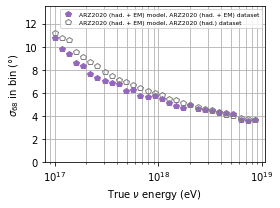

In [4]:

# Imports
import matplotlib.pyplot as plt
import numpy as np
import sys
import argparse
import os
import time
import pickle
from NuRadioReco.utilities import units
from scipy import stats
from itertools import product, combinations
from radiotools import plthelpers as php
from tensorflow import keras
from radiotools import helper as hp
# -------

# Set the figsize in order to get larger text in image
plt.rcParams["figure.figsize"] = (4.0,3.0)

def plot_same(x_data_1, x_data_2, ax1_data_y_1, ax1_data_y_2, ax2_data_y_1, ax2_data_y_2):
    print(f"Plotting {file_name}...")

    fig_same, ax1 = plt.subplots()

    ax1.set_xlabel(x_label)
    ax1.set_ylabel(ax1_y_label)

    # Set ax1 to high order to make it be in front so label is in front, and datapoints
    #ax1.set_zorder(1)

    if file_name == "nu_energy":
        ax1.set_xscale('log')

    # Remove last peices of data as their bins are weird for some azimuth
    if file_name == "nu_energy" or file_name == "nu_azimuth" or file_name == "nu_SNR":
        x_data_1 = x_data_1[0:-1]
        x_data_2 = x_data_2[0:-1]
        ax1_data_y_1 = ax1_data_y_1[0:-1]
        ax1_data_y_2 = ax1_data_y_2[0:-1]

    # Remove any bins with zero events for nu_zenith
    if file_name == "nu_zenith":
        ind_count_not_0 = ax2_data_y_1 != 0
        x_data_1 = x_data_1[ind_count_not_0]
        ax1_data_y_1 = ax1_data_y_1[ind_count_not_0]

        ind_count_not_0 = ax2_data_y_2 != 0
        x_data_2 = x_data_2[ind_count_not_0]
        ax1_data_y_2 = ax1_data_y_2[ind_count_not_0]

    # # Remove last peices of data as their bins are weird for some azimuth
    # if file_name == "shower_energy" or file_name == "nu_azimuth" or file_name == "nu_SNR":
    #     x_data_1 = x_data_1[0:-1]
    #     x_data_2 = x_data_2[0:-1]
    #     x_data_3 = x_data_3[0:-1]
    #     ax1_data_y_1 = ax1_data_y_1[0:-1]
    #     ax1_data_y_2 = ax1_data_y_2[0:-1]
    #     ax1_data_y_3 = ax1_data_y_3[0:-1]

    # Remove any bins with zero events for nu_zenith
    # if file_name == "nu_zenith":
    #     ind_count_not_0 = ax2_data_y_1 != 0
    #     x_data_1 = x_data_1[ind_count_not_0]
    #     ax1_data_y_1 = ax1_data_y_1[ind_count_not_0]

    #     ind_count_not_0 = ax2_data_y_2 != 0
    #     x_data_2 = x_data_2[ind_count_not_0]
    #     ax1_data_y_2 = ax1_data_y_2[ind_count_not_0]

    #     ind_count_not_0 = ax2_data_y_3 != 0
    #     x_data_3 = x_data_3[ind_count_not_0]
    #     ax1_data_y_3 = ax1_data_y_3[ind_count_not_0]

    # lns1 = ax1.plot(x_data_1, ax1_data_y_1, "*", color=ax1_color, label = emission_models[0])
    # lns2 = ax1.plot(x_data_2, ax1_data_y_2, "*", color=ax1_color, label = emission_models[1])
    # lns3 = ax1.plot(x_data_3, "*", color=ax1_color, label = emission_models[2])

    lns1 = ax1.plot(x_data_1, ax1_data_y_1, point_format[0], label = emission_models[0], color=colours[0], fillstyle=fillstyle[0])
    lns2 = ax1.plot(x_data_2, ax1_data_y_2, point_format[1], label = emission_models[1], color=colours[1], fillstyle=fillstyle[1])

    # Set axis limits so they are same on all plots
    # Set axis limits so they are same on all plots
    if file_name == "nu_energy":
        ax1.set_ylim(0, 13.5)
    elif file_name == "nu_SNR":
        ax1.set_ylim(0, 22.5)
    elif file_name == "nu_zenith":
        ax1.set_ylim(0, 10)
    elif file_name == "nu_azimuth":
        ax1.set_ylim(0, 8)

    # plt.title(plot_title)
    plt.grid(True, which="both")

    ax1.legend(prop={'size': 6})

    fig_same.tight_layout()  # otherwise the right y-label is slightly clipped

    #plt.subplots_adjust(top=0.88)
    fig_same.savefig(f"{plot_dir}/{plot_name_prepend}_{file_name}_same_statistic_{statistic_string}.pdf", bbox_inches='tight')



# Save the run name
# run_names = ["run_HAD_vs_EMHAD", "run_EMHAD_vs_HAD"]
# emission_models = ["ARZ2020 (had.) model, ARZ2020 (had. + EM) dataset", "ARZ2020 (had. + EM) model, ARZ2020 (had.) dataset"]
# colours = ["tab:green", "tab:red"]
# point_format = ["v", "P"]

# plot_name_prepend = "ARZHAD_vs_ARZHADEM_model:ARZHAD"
# run_names = ["run_ARZHAD_vs_ARZHAD",
#             "run_ARZHAD_vs_ARZHADEM", 
#             "run_ARZHADEM_vs_ARZHADEM", 
#             "run_ARZHADEM_vs_ARZHAD"]

# emission_models = ["ARZ2020 (had.) model, ARZ2020 (had.) dataset", 
#                     "ARZ2020 (had.) model, ARZ2020 (had. + EM) dataset",
#                     "ARZ2020 (had. + EM) model, ARZ2020 (had. + EM) dataset", 
#                     "ARZ2020 (had. + EM) model, ARZ2020 (had.) dataset",
#                     ]
# colours = ["tab:red", "tab:gray", "tab:purple", "tab:gray"]
# point_format = ["P", "P", "p", "p"]

plot_name_prepend = "ARZHAD_vs_ARZHADEM_model:ARZHAD"
run_names = ["run_ARZHAD_vs_ARZHAD",
            "run_ARZHAD_vs_ARZHADEM", ]

emission_models = ["ARZ2020 (had.) model, ARZ2020 (had.) dataset", 
                    "ARZ2020 (had.) model, ARZ2020 (had. + EM) dataset",
                    ]
colours = ["tab:red", "tab:gray"]
point_format = ["P", "P"]
fillstyle = ["full", "none"]

# plot_name_prepend = "ARZHAD_vs_ARZHADEM_model:ARZHADEM"
# run_names = ["run_ARZHADEM_vs_ARZHADEM", 
#              "run_ARZHADEM_vs_ARZHAD" ]

# emission_models = ["ARZ2020 (had. + EM) model, ARZ2020 (had. + EM) dataset", 
#                     "ARZ2020 (had. + EM) model, ARZ2020 (had.) dataset",
#                     ]
# colours = ["tab:purple", "tab:gray"]
# point_format = ["p", "p"]
# fillstyle = ["full", "none"]

# plot_name_prepend = "ARZHAD_vs_ALVAREZHAD_model:ARZHAD"
# run_names = ["run_ARZHAD_vs_ARZHAD",
#             "run_ARZHAD_vs_ALVAREZHAD", ]

# emission_models = ["ARZ2020 (had.) model, ARZ2020 (had.) dataset", 
#                     "ARZ2020 (had.) model, Alvarez2009 (had.) dataset",
#                     ]
# colours = ["tab:red", "tab:gray"]
# point_format = ["P", "P"]
# fillstyle = ["full", "none"]

# plot_name_prepend = "ARZHAD_vs_ALVAREZHAD_model:ALVAREZHAD"
# run_names = ["run_ALVAREZHAD_vs_ALVAREZHAD",
#             "run_ALVAREZHAD_vs_ARZHAD", ]

# emission_models = ["Alvarez2009 (had.) model, Alvarez2009 (had.) dataset", 
#                     "Alvarez2009 (had.) model, ARZ2020 (had.) dataset",
#                     ]
# colours = ["tab:green", "tab:gray"]
# point_format = ["v", "v"]
# fillstyle = ["full", "none"]


print(colored(f"Plotting SAMEPLOTS resolution as function of neutrino properties for...", "yellow"))


# See which statistic to calculate...
statistic_string = "SIXTYEIGHT"
print(f"Calulating with statistic {statistic_string}...")


# Make sure plots folder exists
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

plot_dir = f"{plots_dir}"

# Make sure folder inside plot_folder exists for the plots
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Make sure same_data file exists
same_data_file = f'{plots_dir}/plotdata_SIXTYEIGHT_{run_names[0]}.npy'
if not os.path.isfile(same_data_file):
    print("Same datafile does not exist!")
    raise Exception

# Load same data file
with open(same_data_file, 'rb') as f:
    nu_energy_bins_1 = np.load(f)
    binned_resolution_nu_energy_1 = np.load(f)
    binned_resolution_nu_energy_count_1 = np.load(f)

    nu_azimuth_bins_1 = np.load(f)
    binned_resolution_nu_azimuth_1 = np.load(f)
    binned_resolution_nu_azimuth_count_1 = np.load(f)

    nu_zenith_bins_1 = np.load(f)
    binned_resolution_nu_zenith_1 = np.load(f)
    binned_resolution_nu_zenith_count_1 = np.load(f)

    SNR_means_1 = np.load(f)
    binned_resolution_SNR_mean_1 = np.load(f)
    binned_resolution_SNR_mean_count_1 = np.load(f)

# Make sure same_data file exists
same_data_file = f'{plots_dir}/plotdata_SIXTYEIGHT_{run_names[1]}.npy'
if not os.path.isfile(same_data_file):
    print("Same datafile does not exist!")
    raise Exception

# Load same data file
with open(same_data_file, 'rb') as f:
    nu_energy_bins_2 = np.load(f)
    binned_resolution_nu_energy_2 = np.load(f)
    binned_resolution_nu_energy_count_2 = np.load(f)

    nu_azimuth_bins_2 = np.load(f)
    binned_resolution_nu_azimuth_2 = np.load(f)
    binned_resolution_nu_azimuth_count_2 = np.load(f)

    nu_zenith_bins_2 = np.load(f)
    binned_resolution_nu_zenith_2 = np.load(f)
    binned_resolution_nu_zenith_count_2 = np.load(f)

    SNR_means_2 = np.load(f)
    binned_resolution_SNR_mean_2 = np.load(f)
    binned_resolution_SNR_mean_count_2 = np.load(f)


sigma_68_string = "_{68}"

ax2_data_y_1 = binned_resolution_nu_zenith_count_1
ax2_data_y_2 = binned_resolution_nu_zenith_count_2

# Energy resolution & count on same axis
# Constants:
ax1_color = 'tab:blue'
ax2_color = 'tab:orange'
x_label = r"True $\nu$ energy (eV)"
ax1_y_label = fr"$\sigma{sigma_68_string}$ in bin (°)"
ax2_y_label = "Events"

x_data_1 = nu_energy_bins_1
x_data_2 = nu_energy_bins_2
ax1_data_y_1 = binned_resolution_nu_energy_1
ax1_data_y_2 = binned_resolution_nu_energy_2


file_name = "nu_energy"
# plot_title = fr"Value of $\sigma{sigma_68_string}$ as a function of $\nu$ energy"
plot_title = ""
legend_loc = "upper center"
# Constants END

plot_same(x_data_1, x_data_2, ax1_data_y_1, ax1_data_y_2, ax2_data_y_1, ax2_data_y_2)
# ______________________________________


# Azimuth resolution & count on same axis
# Constants:
x_label = r"True $\nu$ azimuth angle (°)"
ax1_y_label = fr"$\sigma{sigma_68_string}$ in bin (°)"
ax2_y_label = "Events"

x_data_1 = nu_azimuth_bins_1
x_data_2 = nu_azimuth_bins_2
ax1_data_y_1 = binned_resolution_nu_azimuth_1
ax1_data_y_2 = binned_resolution_nu_azimuth_2


file_name = "nu_azimuth"
# plot_title = fr"Value of $\sigma{sigma_68_string}$ as a function of $\nu$ azimuth angle"
plot_title = ""
legend_loc = "upper right"
# Constants END

# plot_same(x_data_1, x_data_2, ax1_data_y_1, ax1_data_y_2, ax2_data_y_1, ax2_data_y_2)
# ______________________________________



# Zenith resolution & count on same axis
# Constants:
x_label = r"True $\nu$ zenith angle (°)"
ax1_y_label = fr"$\sigma{sigma_68_string}$ in bin (°)"
ax2_y_label = "Events"

x_data_1 = nu_zenith_bins_1
x_data_2 = nu_zenith_bins_2
ax1_data_y_1 = binned_resolution_nu_zenith_1
ax1_data_y_2 = binned_resolution_nu_zenith_2


file_name = "nu_zenith"
# plot_title = fr"Value of $\sigma{sigma_68_string}$ as a function of $\nu$ zenith angle"
plot_title = ""
legend_loc = "upper left"
# Constants END

# plot_same(x_data_1, x_data_2, ax1_data_y_1, ax1_data_y_2, ax2_data_y_1, ax2_data_y_2)
# ______________________________________


# SNR resolution & count on same axis
# Constants:
x_label = r"Event SNR"
ax1_y_label = fr"$\sigma{sigma_68_string}$ in bin (°)"
ax2_y_label = "Events"

x_data_1 = SNR_means_1
x_data_2 = SNR_means_2
ax1_data_y_1 = binned_resolution_SNR_mean_1
ax1_data_y_2 = binned_resolution_SNR_mean_2


file_name = "nu_SNR"
# plot_title = fr"Value of $\sigma{sigma_68_string}$ as a function of event SNR"
plot_title = ""
legend_loc = "upper right"
# Constants END

# plot_same(x_data_1, x_data_2, ax1_data_y_1, ax1_data_y_2, ax2_data_y_1, ax2_data_y_2)
# ______________________________________

print(colored(f"Plotting  SAMEGRAPHG angular resolution depending on properties!", "green", attrs=["bold"]))
print("")
